# Mercedes-Benz Greener Manufacturing

Reduce the time a Mercedes-Benz spends on the test bench.

Problem Statement Scenario:
Since the first automobile, the Benz Patent Motor Car in 1886, Mercedes-Benz has stood for important automotive innovations. These include the passenger safety cell with a crumple zone, the airbag, and intelligent assistance systems. Mercedes-Benz applies for nearly 2000 patents per year, making the brand the European leader among premium carmakers. Mercedes-Benz is the leader in the premium car industry. With a huge selection of features and options, customers can choose the customized Mercedes-Benz of their dreams.

To ensure the safety and reliability of every unique car configuration before they hit the road, the company’s engineers have developed a robust testing system. As one of the world’s biggest manufacturers of premium cars, safety and efficiency are paramount on Mercedes-Benz’s production lines. However, optimizing the speed of their testing system for many possible feature combinations is complex and time-consuming without a powerful algorithmic approach.

You are required to reduce the time that cars spend on the test bench. Others will work with a dataset representing different permutations of features in a Mercedes-Benz car to predict the time it takes to pass testing. Optimal algorithms will contribute to faster testing, resulting in lower carbon dioxide emissions without reducing Mercedes-Benz’s standards.

Following actions should be performed:

1. If for any column(s), the variance is equal to zero, then you need to remove those variable(s).
2. Check for null and unique values for test and train sets.
3. Apply label encoder.
4. Perform dimensionality reduction.
5. Predict your test_df values using XGBoost.

In [9]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [10]:
# Import Datasets

train_original = pd.read_csv("train.csv")
test_original = pd.read_csv("test.csv")

In [11]:
print("Train shape:", train_original.shape)
print("Test shape:", test_original.shape)

Train shape: (4209, 378)
Test shape: (4209, 377)


In [12]:
train_original.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


In [13]:
test_original.head()

,ID,X0,X1,X2,X3,X4,X5,X6,X8,X10,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,1,az,v,n,f,d,t,a,w,0,...,0,0,0,1,0,0,0,0,0,0
1,2,t,b,ai,a,d,b,g,y,0,...,0,0,1,0,0,0,0,0,0,0
2,3,az,v,as,f,d,a,j,j,0,...,0,0,0,1,0,0,0,0,0,0
3,4,az,l,n,f,d,z,l,n,0,...,0,0,0,1,0,0,0,0,0,0
4,5,w,s,as,c,d,y,i,m,0,...,1,0,0,0,0,0,0,0,0,0


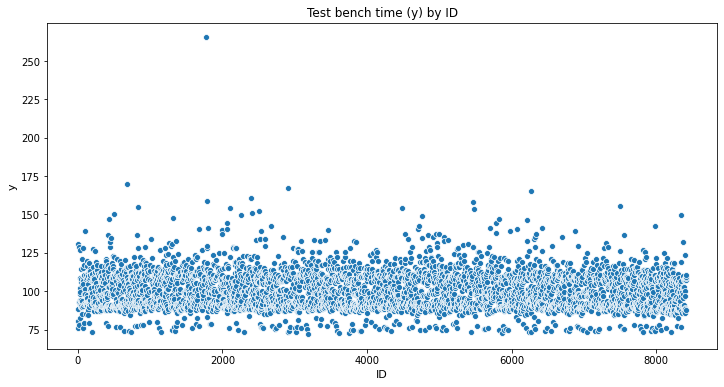

In [15]:
# let's see the distribution for the target variable y

plt.figure(figsize=(12,6))
sns.scatterplot(x=train_original["ID"], y=train_original["y"])
plt.xlabel("ID", fontsize=11)
plt.ylabel("y", fontsize=11)
plt.title("Test bench time (y) by ID", fontsize=12)
plt.show()

In [16]:
# From the scatter plot we see an outlier, which should be removed
train_original = train_original[train_original["y"]<200]
train_original.shape

(4208, 378)

### 1) If for any column(s), the variance is equal to zero, then you need to remove those variable(s).

In [17]:
# We need to check the variance of the variables of the train set.

train = train_original.copy()
test = test_original.copy()

# As we can see, the var() method doesn't include de categorical variables in the output. 
# In case of train set, there is a difference of 8 columns.
pd.DataFrame(train_original.var()).T

,ID,y,X10,X11,X12,X13,X14,X15,X16,X17,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,5.941938e+06,154.359407,0.013134,0.0,0.069472,0.054636,0.244908,0.000475,0.002608,0.007549,...,0.21726,0.054005,0.215781,0.020252,0.009418,0.008016,0.007549,0.001661,0.000475,0.001424


In [18]:
# We check the features with 0 variance in the train set since they don't bring any information to build the model (constant variables). 
# We eliminate those features from both train and test sets.

for i in range(len(train_original.var())):

    if train_original.var()[i]==0:
           
            # 8 is the difference in index value without the categorical variables respect to the output of the var() method.
            train.drop(train.columns[[i+8]], axis=1, inplace=True)
            
            # 7 is the difference in index value without the categorial variables (no target variable) respect to the output of the var() method.
            test.drop(test.columns[[i+7]], axis=1, inplace=True)
                       
print("Train shape after dropping 0-variance columns: ", train.shape)
print("Test shape after dropping 0-variance columns: ", test.shape)
train.head()

Train shape after dropping 0-variance columns:  (4208, 366)
Test shape after dropping 0-variance columns:  (4209, 365)


,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,k,v,at,a,d,u,j,o,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,k,t,av,e,d,y,l,o,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,az,w,n,c,d,x,j,x,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,az,t,n,f,d,x,l,e,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,az,v,n,f,d,h,d,n,...,0,0,0,0,0,0,0,0,0,0


### 2) Check for null and unique values for test and train sets.

In [19]:
# We check for null values in train and test data

print("Null values in train data: ", train.isnull().sum().sum())
print("Null vales in test data: ", test.isnull().sum().sum())

Null values in train data:  0
Null vales in test data:  0


In [20]:
# We check how many categorical variables there are
train.iloc[:,0:15].dtypes

ID       int64
y      float64
X0      object
X1      object
X2      object
X3      object
X4      object
X5      object
X6      object
X8      object
X10      int64
X12      int64
X13      int64
X14      int64
X15      int64
dtype: object

##### As we can see, there are 8 categorical variables, which we saw previously from the output of the var().

In [21]:
# We check for unique values in categorical columns of train dataset

for col, value in enumerate(train.columns[2:10], start=2):
    print(train.columns[col])
    print("Unique values: ", train[value].unique())
    print("Number of unique values: ", train[value].nunique())

X0
Unique values:  ['k' 'az' 't' 'al' 'o' 'w' 'j' 'h' 's' 'n' 'ay' 'f' 'x' 'y' 'aj' 'ak' 'am'
 'z' 'q' 'at' 'ap' 'v' 'af' 'a' 'e' 'ai' 'd' 'aq' 'c' 'aa' 'ba' 'as' 'i'
 'r' 'b' 'ax' 'bc' 'u' 'ad' 'au' 'm' 'l' 'aw' 'ao' 'ac' 'g' 'ab']
Number of unique values:  47
X1
Unique values:  ['v' 't' 'w' 'b' 'r' 'l' 's' 'aa' 'c' 'a' 'e' 'h' 'z' 'j' 'o' 'u' 'p' 'n'
 'i' 'y' 'd' 'f' 'm' 'k' 'g' 'q' 'ab']
Number of unique values:  27
X2
Unique values:  ['at' 'av' 'n' 'e' 'as' 'aq' 'r' 'ai' 'ak' 'm' 'a' 'k' 'ae' 's' 'f' 'd'
 'ag' 'ay' 'ac' 'ap' 'g' 'i' 'aw' 'y' 'b' 'ao' 'al' 'h' 'x' 'au' 't' 'an'
 'z' 'ah' 'p' 'am' 'j' 'q' 'af' 'l' 'aa' 'c' 'o' 'ar']
Number of unique values:  44
X3
Unique values:  ['a' 'e' 'c' 'f' 'd' 'b' 'g']
Number of unique values:  7
X4
Unique values:  ['d' 'b' 'c' 'a']
Number of unique values:  4
X5
Unique values:  ['u' 'y' 'x' 'h' 'g' 'f' 'j' 'i' 'd' 'c' 'af' 'ag' 'ab' 'ac' 'ad' 'ae'
 'ah' 'l' 'k' 'n' 'm' 'p' 'q' 's' 'r' 'v' 'w' 'o' 'aa']
Number of unique values:  29
X6
Unique v

In [22]:
# Same for test dataset

for col, value in enumerate(test.columns[1:9], start=1):
    print(test.columns[col])
    print("Unique values: ", test[value].unique())
    print("Number of unique values: ", test[value].nunique())

X0
Unique values:  ['az' 't' 'w' 'y' 'x' 'f' 'ap' 'o' 'ay' 'al' 'h' 'z' 'aj' 'd' 'v' 'ak'
 'ba' 'n' 'j' 's' 'af' 'ax' 'at' 'aq' 'av' 'm' 'k' 'a' 'e' 'ai' 'i' 'ag'
 'b' 'am' 'aw' 'as' 'r' 'ao' 'u' 'l' 'c' 'ad' 'au' 'bc' 'g' 'an' 'ae' 'p'
 'bb']
Number of unique values:  49
X1
Unique values:  ['v' 'b' 'l' 's' 'aa' 'r' 'a' 'i' 'p' 'c' 'o' 'm' 'z' 'e' 'h' 'w' 'g' 'k'
 'y' 't' 'u' 'd' 'j' 'q' 'n' 'f' 'ab']
Number of unique values:  27
X2
Unique values:  ['n' 'ai' 'as' 'ae' 's' 'b' 'e' 'ak' 'm' 'a' 'aq' 'ag' 'r' 'k' 'aj' 'ay'
 'ao' 'an' 'ac' 'af' 'ax' 'h' 'i' 'f' 'ap' 'p' 'au' 't' 'z' 'y' 'aw' 'd'
 'at' 'g' 'am' 'j' 'x' 'ab' 'w' 'q' 'ah' 'ad' 'al' 'av' 'u']
Number of unique values:  45
X3
Unique values:  ['f' 'a' 'c' 'e' 'd' 'g' 'b']
Number of unique values:  7
X4
Unique values:  ['d' 'b' 'a' 'c']
Number of unique values:  4
X5
Unique values:  ['t' 'b' 'a' 'z' 'y' 'x' 'h' 'g' 'f' 'j' 'i' 'd' 'c' 'af' 'ag' 'ab' 'ac'
 'ad' 'ae' 'ah' 'l' 'k' 'n' 'm' 'p' 'q' 's' 'r' 'v' 'w' 'o' 'aa']
Number of u

##### We oberve that there are some extra unique values in some test dataset columns (X0, X2, X5) that are not present in the train set, which might lead the model to not learn as good as it could.

### 3) Apply label encoder.

In [23]:
# Since this is a large dataset (366 columns so far), we'll apply Label Encoder to the categorical variables.
# If the dataset was smaller, we would ideally apply One-Hot-Encoding, but the number of columns would increase too much and therefore the complexity of the model.

from sklearn.preprocessing import LabelEncoder

# Columns where we want to apply LabelEncoder
cols = ["X0", "X1", "X2", "X3", "X4", "X5", "X6", "X8"]

label_encoder = LabelEncoder()
train[cols] = train[cols].apply(LabelEncoder().fit_transform)
test[cols] = test[cols].apply(LabelEncoder().fit_transform)

train.head()

,ID,y,X0,X1,X2,X3,X4,X5,X6,X8,...,X375,X376,X377,X378,X379,X380,X382,X383,X384,X385
0,0,130.81,32,23,17,0,3,24,9,14,...,0,0,1,0,0,0,0,0,0,0
1,6,88.53,32,21,19,4,3,28,11,14,...,1,0,0,0,0,0,0,0,0,0
2,7,76.26,20,24,34,2,3,27,9,23,...,0,0,0,0,0,0,1,0,0,0
3,9,80.62,20,21,34,5,3,27,11,4,...,0,0,0,0,0,0,0,0,0,0
4,13,78.02,20,23,34,5,3,12,3,13,...,0,0,0,0,0,0,0,0,0,0


### 4) Perform dimensionality reduction.

In [24]:
# Since we we are dealing with a regression problem (and not a classification problem - LDA) , we'll apply PCA.

from sklearn.decomposition import PCA

# We drop the target column to apply PCA
X_train = train.drop(["y"], axis=1)
y_train = train["y"]

pc = PCA()
X_train_pca = pc.fit_transform(X_train)
X_test_pca = pc.fit_transform(test)

pc.explained_variance_ratio_

array([9.99908914e-01, 4.20611047e-05, 1.70823117e-05, 1.09022238e-05,
       8.34605779e-06, 7.40089097e-06, 1.38579687e-06, 6.96410620e-07,
       3.88704816e-07, 2.55669071e-07, 2.20120807e-07, 2.05647442e-07,
       1.76189346e-07, 1.50486671e-07, 1.28680187e-07, 1.11391290e-07,
       9.54965624e-08, 8.49358688e-08, 7.88149539e-08, 6.83336374e-08,
       6.33271440e-08, 5.98278260e-08, 5.41372773e-08, 5.13967206e-08,
       4.53038727e-08, 4.14421316e-08, 3.89347668e-08, 3.68425979e-08,
       3.44790869e-08, 3.34598290e-08, 3.23706447e-08, 2.96725736e-08,
       2.74682332e-08, 2.71829471e-08, 2.54680575e-08, 2.29518619e-08,
       2.19044212e-08, 2.05054665e-08, 2.00714242e-08, 1.73633513e-08,
       1.67935550e-08, 1.65637830e-08, 1.56072590e-08, 1.51856208e-08,
       1.49253946e-08, 1.40034714e-08, 1.33268595e-08, 1.30188626e-08,
       1.27297003e-08, 1.22379885e-08, 1.16791631e-08, 1.14144552e-08,
       1.10812399e-08, 1.08210215e-08, 1.01427471e-08, 9.40442080e-09,
      

##### From the result, we see that the the first component captures 99.99 % of the total variance, so it is enough to build our model.

In [25]:
# We use the first PCA for our model

pc2 = PCA(n_components = 1)

x_train_pca2 = pc2.fit_transform(X_train)
x_test_pca2 = pc2.fit_transform(test)

### 5) Predict your test_df values using XGBoost.

In [26]:
# We use XGBoost to predict the values.

import xgboost as xgb

# To be able to evaluate the model we are going to use a validation set, splitting the train dataset into train and validation.
# This way we will be able to compare and calculate RMSE values

X_train2, X_val, y_train2, y_val = train_test_split(x_train_pca2, y_train , test_size = 0.2, random_state = 11)

# Convert to DMatrix format
D_train2 = xgb.DMatrix(X_train2, y_train2)
D_val = xgb.DMatrix(X_val)
D_train_2 = xgb.DMatrix(X_train2)

# We initialize the parameters
params = {"booster":"gblinear"}

# We train the model using train subset and predict y using train validation subset
xgb_model = xgb.train(params, D_train2, 20)
xgb_y_val = xgb_model.predict(D_val)

# We predict y train subset using train subset
xgb_X_train = xgb_model.predict(D_train2, 20)

In [27]:
# We evaluate the performance of the model using the subtrain and validation set

from sklearn.metrics import mean_squared_error

print("The RMSE value of the train dataset is : ", np.sqrt(mean_squared_error(y_train2, xgb_X_train)))
print("The RMSE value of the validation dataset is : ", np.sqrt(mean_squared_error(y_val, xgb_y_val)))

The RMSE value of the train dataset is :  12.456265458426145
The RMSE value of the validation dataset is :  12.203468037892183


##### As we see, the RMSE values for train and test don't differ much, so we can conclude that there is not overfitting or underfitting and therefore the model works well

In [28]:
# We apply the model using the full train set to predict the values

D_train = xgb.DMatrix(x_train_pca2, y_train)
D_test = xgb.DMatrix(x_test_pca2)

# We initialize the parameters
params = {"booster":"gblinear"}

# We train the model using train subset and predict y using train validation subset
xgb_model2 = xgb.train(params, D_train, 20)
xgb_y_pred = xgb_model.predict(D_test)

In [39]:
y_pred = pd.DataFrame({"Predicted time": xgb_y_pred})
y_pred.head(15).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
Predicted time,99.620972,99.621239,99.621513,99.621803,99.622078,99.62291,99.623459,99.623726,99.624001,99.624557,99.624832,99.625107,99.625381,99.625938,99.626213


### End of the project